## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Installing TensorFlow

In [ ]:
import tensorflow as tf
tf.__version__

'2.11.0'

####Changing Working Directory to Directory where data is stored

In [ ]:
cd /content/drive/My Drive/AI content

/content/drive/My Drive/AI content


####loading in the packages

In [ ]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Setting the path and annot to the address of your image folder and Airplanes_Annotations folder.

In [ ]:
path = "/content/drive/My Drive/AI content/Images"
annot = "/content/drive/My Drive/AI content/Airplanes_Annotations"

Our airplane dataset contains two parts

Image part-> Contain pictures of airplanes


Airplanes_Annotations-> Contain information about bounding boxes for the pictures available.

In [ ]:
Index = input()

In [ ]:
filename = "airplane_"+str(Index)+".jpg"
print(filename)

In the following code, the first line reads an image file named filename located in the directory specified by path using OpenCV's imread() function. The image is loaded into the img variable.

os.path.join() is a function provided by the os module that ensures file path concatenation is done correctly for different operating systems.

The second line reads a CSV file named filename.replace(".jpg",".csv") located in the directory specified by annot using Pandas' read_csv() function. The replace() method replaces the file extension .jpg with .csv in the filename. The data from the CSV file is loaded into the df variable.

The third line displays the image loaded into the img variable using Matplotlib's imshow() function. The image is displayed as a plot in a new window.

In [ ]:
img = cv2.imread(os.path.join(path,filename))
df = pd.read_csv(os.path.join(annot,filename.replace(".jpg",".csv")))
plt.imshow(img)

In [ ]:
df

In [ ]:
df.shape

In [ ]:
for row in df.iterrows():
    x1 = int(row[1][0].split(" ")[0])
    y1 = int(row[1][0].split(" ")[1])
    x2 = int(row[1][0].split(" ")[2])
    y2 = int(row[1][0].split(" ")[3])
    cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
plt.figure()
plt.imshow(img)

#Selective Search

In [ ]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

***cv2*** is a Python module that provides interfaces for working with the OpenCV computer vision library.

***setUseOptimized(True)*** is a function provided by OpenCV that enables optimization of OpenCV code. When optimization is enabled, OpenCV will attempt to use optimized implementations of certain functions and algorithms to improve performance.

***ximgproc*** is a Python module that provides additional functions and algorithms for image processing and computer vision tasks. The ximgproc module is part of OpenCV's extra modules, which contain additional algorithms and functions that are not included in the main OpenCV distribution.

***segmentation*** is a submodule of ximgproc that provides functions and classes for image segmentation tasks. Image segmentation is the process of dividing an image into multiple regions or segments, each of which represents a different object or part of the image. The segmentation submodule provides several different algorithms and classes for image segmentation tasks, including Selective Search.

***createSelectiveSearchSegmentation()*** is a function provided by OpenCV's ximgproc.segmentation module that creates an instance of a Selective Search segmentation object. Selective Search is an algorithm used in computer vision for object detection and image segmentation. The algorithm works by grouping similar regions of an image together based on color, texture, and other properties, and then gradually merging these regions to form larger segments.

In [ ]:
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = img.copy()

***ss.setBaseImage(im)***: This sets the base image for a Selective Search segmentation object named ss to the image stored in the img variable. The base image is the image that the Selective Search algorithm will operate on.

***ss.switchToSelectiveSearchFast()***: This configures the Selective Search segmentation object to use a fast mode for generating region proposals. This mode is faster than other modes but may result in lower quality region proposals.

**rects = ss.process()**: This line generates region proposals for the base image using the Selective Search algorithm and the process() method of the ss object. The resulting regions are stored in a variable named rects, which is a list of bounding box coordinates for each proposed region.

**imOut = img.copy()**: This line creates a copy of the base image stored in the img variable using the copy() method of the img object. This copy will be used later to draw bounding boxes around the proposed regions.

In [ ]:
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

**(0, 255, 0)**: The fourth argument is a tuple representing the color of the rectangle in BGR format. In this case, the rectangle will be green because it has a BGR value of (0, 255, 0).

***cv2.LINE_AA***: The sixth argument is an optional flag that specifies the type of line to be drawn. In this case, cv2.LINE_AA specifies that an anti-aliased line should be drawn, which will make the edges of the rectangle smoother

# Intersection Over Union

In order to apply Intersection over Union to evaluate an (arbitrary) object detector we need:

1. The ground-truth bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is). 

2. The predicted bounding boxes from our model.


After getting these two we can find there intersection and union area,whih ultimately gives us our IoU.

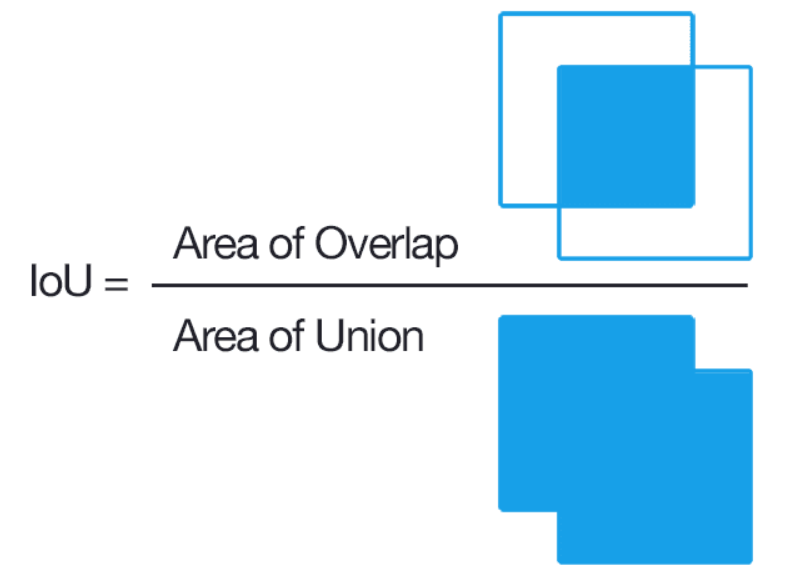






we now take :
1. x1 = x
2. y1 = y
3. x2 = x+w
4. y2 = y+h

In [ ]:
def get_iou(bb1, bb2):

  # assuring for proper dimension.
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

  # calculating dimension of common area between these two boxes.
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

  # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0

  # calculating intersection area.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

  # individual areas of both these bounding boxes.
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

  # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

We use the Python ***assert statement*** to check that the bounding box coordinates are valid.

We also check whether there is any overlap between the two bounding boxes. If there is no overlap, the function returns 0.0 as the IoU is zero.

# Training Data

Training data here is prepared according to following scheme:-
1. Those boxes which have an IoU greater than 0.7 are considered as a positive example.
2. And boxes with relative low IoU 0.3 are taken to be negative examples.
Number of regions taken here is 30 positive and 30 negative of size 224x224.

In [ ]:
train_images=[]
train_labels=[]

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)

            # reading the image
            image = cv2.imread(os.path.join(path,filename))

            # creating a dataframe with all coordinates of the bounding box in the images
            df = pd.read_csv(os.path.join(annot,i))

            # list for grounf truth bounding boxes
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})

            # setting given image as base image
            ss.setBaseImage(image)   

            # running selective search on bae image
            ss.switchToSelectiveSearchFast()    

            # processing to get the outputs  
            ssresults = ss.process()     
            imout = image.copy()   

            # Initializing some variables used in the loop
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0


            for e,result in enumerate(ssresults):

                # till 2000 to get top 2000 regions only
                if e < 2000 and flag == 0:     
                    for gtval in gtvalues:
                        x,y,w,h = result

                        # calculating IoU for each of the proposed regions
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})  

                        # getting only 30 psoitive examples
                        if counter < 30:  
                            
                            # IoU or being positive is 0.7     
                            if iou > 0.70:   

                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1

                        else :

                            # to insure we have collected all positive examples
                            fflag =1      

                        # 30 negatve examples are allowed only
                        if falsecounter <30:      

                            # IoU or being negative is 0.3
                            if iou < 0.3:  

                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1

                        else :

                            #to ensure we have collected all negative examples
                            bflag = 1      

                    if fflag == 1 and bflag == 1:  
                        print("inside")

                        # to signal the complition of data extaction from a particular image
                        flag = 1  
                        
                              
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

"***os.listdir***" lists all the files in the directory

In [ ]:
# conversion of train data into arrays for further training
X_new = np.array(train_images)
Y_new = np.array(train_labels)

## Loading the packages

In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers

1. ***Dense***: This is a class in Keras that represents a fully connected layer in a neural network. It has a number of neurons (or units) and an activation function. When applied to an input tensor, it performs a matrix multiplication between the weights of the layer and the input, and then applies the activation function to the result.

2. ***Model***: This is a class in Keras that represents a neural network model. It takes two arguments: an input tensor and an output tensor, and it can contain any number of layers that are connected to each other. It also has methods for training the model, making predictions, and evaluating the performance of the model.

3. **optimizers**: This is a module in Keras that contains various optimization algorithms used for training deep neural networks. It provides classes for different optimization algorithms, such as Stochastic Gradient Descent (SGD), Adam, RMSprop, etc. The optimizer is used to update the weights of the neural network during training, by computing the gradients of the loss function with respect to the weights and adjusting the weights accordingly.

# Pre-training

We perform tansfer-learning as pre-training here as we are using VGG16 net which is already trained on Imagenet. We are going to train a binary classifier by making all layers as untrainble except two last. And then we are going to make a new model which will be stacked on last 2nd output layer.

In [ ]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

553467096/553467096 [==============================] - 8s 0us/step


In [ ]:
for layer in vgg.layers[:-2]:
  layer.trainable = False

In [ ]:
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)  

In [ ]:
model = tf.keras.Model(vgg.input,x)

In [ ]:
model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
model.fit(X_new,Y_new,batch_size = 64,epochs = 3, verbose = 1,validation_split=.05,shuffle = True)

# Making new network with SVM

In [ ]:
svm_image = [];
svm_label = [];

For svm dataset we considered all ground truth bounding boxes as positive examples and those which were having an IOU less than 0.3 as false examples to increase the preciseness.

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3]) 
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
                timage = image[x1:x2,y1:y2]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                svm_image.append(resized)
                svm_label.append([0,1])
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if falsecounter <5:
                            if iou < 0.3:
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                svm_image.append(resized)
                                svm_label.append([1,0])
                                falsecounter += 1
                        else :
                            flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [ ]:
cd "/content/drive/My Drive/AI content"

In [ ]:
#adding svm to last layer
x =model.get_layer('fc2').output
Y = tf.keras.layers.Dense(2)(x)
final_model = tf.keras.Model(model.input,Y)
final_model.compile(loss='hinge',
              optimizer='adam',
              metrics=['accuracy'])
final_model.summary()
final_model.load_weights('my_model_weights.h5')

In [ ]:
hist_final = final_model.fit(np.array(svm_image),np.array(svm_label),batch_size=32,epochs = 20,verbose = 1,shuffle = True,validation_split = 0.05)

##Plotting loss and Analysing losses

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist_final.history['loss'])
plt.plot(hist_final.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

# Testing

In [ ]:
###########  it's time for test a image    ##########
image = cv2.imread(os.path.join(path,'airplane_020.jpg'))
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

imOut = image.copy()
boxes = []
count = 0
for e,result in enumerate(ssresults):
  if e < 50:
    x,y,w,h = result
    timage = imout[x:x+w,y:y+h]
    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
    resized = np.expand_dims(resized,axis = 0)
    out = final_model.predict(resized)
    print(e,out)
    if(out[0][0]